# <font color='green'>`DebyeCalculator` Demo!</font>
---

### Made for **EPDIC18:** Padua, Italy, 2024 ☀️

**Authors:** Johansen & Anker et. al.

**Questions:** [frjo@di.ku.dk](frjo@di.ku.dk) and [andy@chem.ku.dk](andy@chem.ku.dk)

**Date:** August 2024

<img src="logo_DebyeCalculator.png" alt="drawing" width="250"/>

[![DOI](https://joss.theoj.org/papers/10.21105/joss.06024/status.svg)](https://doi.org/10.21105/joss.06024)


---
`DebyeCalculator` is a powerful tool for calculating the scattering intensity $I(Q)$ through the Debye scattering equation, the Total Scattering Structure Function $S(Q)$, the Reduced Total Scattering Function $F(Q)$, and the Reduced Atomic Pair Distribution Function $G(r)$.
This class is optimized to run on GPUs, making it well-suited for large-scale simulations and nanoparticle analysis. It utilizes PyTorch to efficiently perform tensor computations and takes advantage of CUDA acceleration for enhanced speed.

In this notebook, we will demonstrate how to use the `DebyeCalculator` class to calculate scattering for discrete nanoparticles, as well as show some of its many capabilities.

---
## <font color='green'>Just One Line to Get Started!</font>
Before diving into the details of the `DebyeCalculator` class and its core functionalities, let’s keep things simple.

**To start using DebyeCalculator, all it takes is this single import:**

In [1]:
from debyecalculator import DebyeCalculator

For the upcoming examples, we'll import a few helper functions to generate different types of particles, as well as utilities for timing operations and visualizing both the particles and their scattering signals.

In [2]:
# Helper functions for generating different particle models
from debyecalculator.utility.generate import (
    generate_core_shell_models, 
    generate_core_shell_models_fixed_size, 
    generate_substitutional_alloy_models,
    generate_periodic_plane_substitution,
    generate_spherical_particle,
)

# Libraries for timing and visualization
import time
import torch
import numpy as np
from tqdm.auto import tqdm, trange

# ASE for particle visualization
from ase.visualize.plot import plot_atoms
from ase.data.colors import jmol_colors
from ase.data import chemical_symbols

# Matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmaps
from matplotlib.patches import Patch
plt.rcParams.update({'font.size': 8, 'lines.linewidth': 1})

---
## Creating an Instance of DebyeCalculator

To start using the DebyeCalculator class, you'll first need to create an instance of it. The class constructor allows you to configure various parameters essential for performing Debye scattering calculations. Here’s how you can set it up:

```python
from debye_calculator import DebyeCalculator

# Create an instance 'calc' of DebyeCalculator
calc = DebyeCalculator(
    qmin=0.0,        # Minimum Q value (1/Å).
    qmax=30.0,       # Maximum Q value (1/Å).
    qstep=0.1,       # Step size for Q (1/Å), Nyquist-sampled by default.
    qdamp=0.0,       # Dampening factor.

    rmin=0.0,        # Minimum R value (Å).
    rmax=20.0,       # Maximum R value (Å).
    rstep=0.01,      # Step size for R (Å).
    rthres=0.0,      # Lower threshold for radial distance (Å) in G(r) calculations.
    
    biso=0.0,        # Isotropic atomic displacement factor (Debye-Waller factor).
    device='cuda',   # Compute on 'cuda' for GPU or 'cpu' for CPU.
    batch_size=None, # Batch size for pairwise distance calculations (auto-determined if not set).
    lorch_mod=False, # Apply Lorch modification factor in G(r) calculations.
    rad_type='xray', # Type of radiation for scattering: 'xray'/'x' or 'neutron'/'n'.
    profile=False,   # Enable profiling for performance analysis.
)

```

In [3]:
# Create a standard instance of DebyeCalculator and print its parameters
calc = DebyeCalculator()
print(calc)

DebyeCalculator instance:
Q-min:        1.00
Q-max:       30.00
Q-step:       0.16
Q-damp:       0.04

r-min:        0.00
r-max:       20.00
r-step:       0.01
r-thres:      0.00

B-iso:        0.30

rad_type:    xray
lorch_mod:   False

batch_size:  10000
device:      cuda
profile:     False



---
## Generating total scattering from `.xyz`-files

Let's explore how to use the `iq` method from the `DebyeCalculator` class to calculate the scattering intensity $I(Q)$ for a particle defined from a `.xyz`-file.

This method takes the `.xyz` file and returns the scattering intensity $I(Q)$ at the specified $Q$ values as so:

```python
# Create an instance of DebyeCalculator with appropriate parameters
calc = DebyeCalculator(qmin=1.0, qmax=30.0, qdamp=0.0)

# Load a single particle from a .xyz file (replace "path/to/nanoparticle.xyz" with your file path)
q, iq = calc.iq("path/to/nanoparticle.xyz")

```
**Note:** This example shows how to compute $I(Q)$ for a single nanoparticle using an `.xyz` file. If you are working with a `.cif` file instead, please refer to the next section for details on how to use it similarly.

##### Let's do it in practice and plot it!

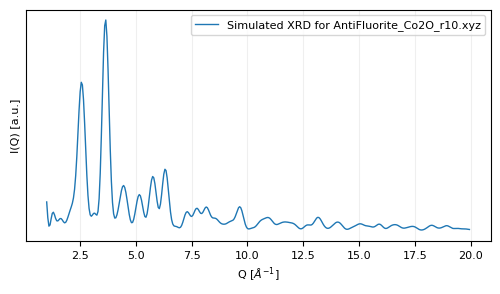

In [4]:
# Generate
calc = DebyeCalculator(qmin=1.0, qmax=20.0, qstep=0.05, qdamp=0.0, biso=0.0)
path_to_xyz_file = "debyecalculator/data/AntiFluorite_Co2O_r10.xyz"
q, iq = calc.iq(path_to_xyz_file)

# Plot
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(q, iq, label=f"Simulated XRD for {path_to_xyz_file.split('/')[-1]}")
ax.set(xlabel='Q [$Å^{-1}$]', ylabel='I(Q) [a.u.]', yticks=[])
ax.grid(alpha=0.2)
ax.legend()
plt.show()

##### Let's try to compare the pattern generated from x-rays and neutrons:
The parameters can be changed on the fly using the build-in ``update_parameters`` method

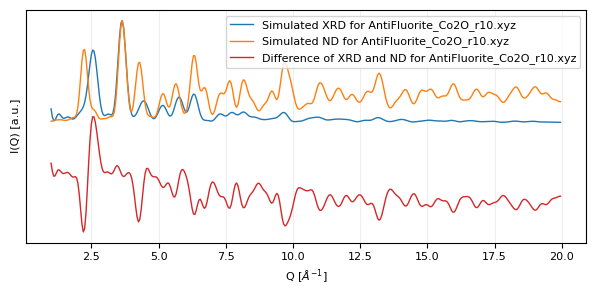

In [5]:
# Make instance (again for the sake of example)
calc = DebyeCalculator(qmin=1.0, qmax=20.0, qstep=0.05, qdamp=0.0, biso=0.15)
path_to_xyz_file = "debyecalculator/data/AntiFluorite_Co2O_r10.xyz"

# Generate XRD
q, iq_xray = calc.iq(path_to_xyz_file)
iq_xray /= max(iq_xray)

# Update and generate ND
calc.update_parameters(rad_type='neutron')
q, iq_neu = calc.iq(path_to_xyz_file)
iq_neu /= max(iq_neu)

# Since the q-range is the same we can compare
fig, ax = plt.subplots(figsize=(6,3))
    
ax.plot(q, iq_xray, label=f"Simulated XRD for {path_to_xyz_file.split('/')[-1]}", c='#1f77b4')
ax.plot(q, iq_neu, label=f"Simulated ND for {path_to_xyz_file.split('/')[-1]}", c='#ff7f0e')
ax.plot(q, iq_xray-iq_neu - .5, label=f"Difference of XRD and ND for {path_to_xyz_file.split('/')[-1]}", c='#d62728')


ax.set(xlabel='Q [$Å^{-1}$]', ylabel='I(Q) [a.u.]', yticks=[])
ax.grid(alpha=0.2)
ax.legend()

fig.tight_layout()
plt.show()

---
## Generating total scattering from `.cif`-files

The `iq` method can also be used to generate a spherical particle from a `.cif`-file based on specific radii and subsequently generate scattering intensities for every particle in the set, at the specified Q values:

```python
# Create an instance of DebyeCalculator with appropriate parameters
calc = DebyeCalculator(qmin=1.0, qmax=30.0, qdamp=0.0)

# Load a .cif-file and generate I(Q) from different sizes spherical particles
# Replace "path/to/crystalfile.cif" with your file path
(q, iq_5), (q, iq_10) = calculator.iq(structure_path = "path/to/crystalfile.cif", radii = [5.0, 10.0])

```

##### Let's do it in practice and plot it!

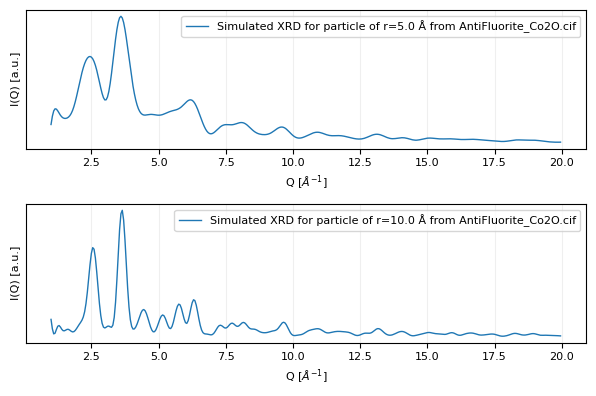

In [6]:
# Generate
calc = DebyeCalculator(qmin=1.0, qmax=20.0, qstep=0.05, qdamp=0.0, biso=0.0)
path_to_xyz_file = "debyecalculator/data/AntiFluorite_Co2O.cif"
radii = [5.0, 10.0] # Å
(q, iq_5), (q, iq_10) = calc.iq(path_to_xyz_file, radii)

# Plot
fig, axes = plt.subplots(2,1,figsize=(6,4))
ax_5, ax_10 = axes

ax_5.plot(q, iq_5, label=f"Simulated XRD for particle of r={radii[0]} Å from {path_to_xyz_file.split('/')[-1]}")
ax_10.plot(q, iq_10, label=f"Simulated XRD for particle of r={radii[1]} Å from {path_to_xyz_file.split('/')[-1]}")

for ax in axes:
    ax.set(xlabel='Q [$Å^{-1}$]', ylabel='I(Q) [a.u.]', yticks=[])
    ax.grid(alpha=0.2)
    ax.legend()

fig.tight_layout()
plt.show()

##### Let's see the size dependence on the PDF in action

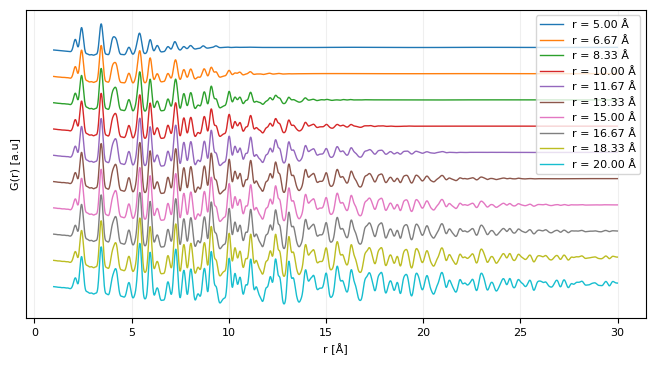

In [7]:
# Generate
calc = DebyeCalculator(rmin=1.0, rmax=30.0)
path_to_xyz_file = "debyecalculator/data/AntiFluorite_Co2O.cif"

N = 10
gr_radii = np.linspace(5.0, 20.0, N) # Å
gr_output = calc.gr(path_to_xyz_file, list(gr_radii))

# Plotting
fig, ax = plt.subplots(figsize=(8, 4))

for i, (x, y) in enumerate(gr_output):
    ax.plot(x, y - i*5, label=f'r = {gr_radii[i]:.2f} Å')

ax.set(xlabel = 'r [Å]', ylabel = 'G(r) [a.u]', yticks=[])
ax.grid(alpha=0.2)
ax.legend(loc='upper right')
plt.show()

## Generating partial-scattering

`DebyeCalculator` allows user to extract the partial scattering of specific pairs of atomic species within structures.

```python
# Create an instance of DebyeCalculator with appropriate parameters
calc = DebyeCalculator(qmin=1.0, qmax=20.0, qdamp=0.0)

# Load a single particle from a .xyz file (replace "path/to/nanoparticle.xyz" with your file path)
# Add the parameter "partial" with a pattern on the form 'X-Y' where 'X' and 'Y' are elements present in the structure.
# These patterns independent of order, meaning 'X-Y' and 'Y-X' will result in the same output.
# You can only extract binary "partials", but these you can combine in any way you like (*)
q, iq_XX = calc.iq("path/to/nanoparticle.xyz", partial = "X-X")
q, iq_YY = calc.iq("path/to/nanoparticle.xyz", partial = "Y-Y")
q, iq_XY = calc.iq("path/to/nanoparticle.xyz", partial = "X-Y")

```
(*) **Note!** that to combine signals from partial scattering, you risk double-counting some of the interactions between atoms -- so be careful. Below we will show how to handle this for a simple example.

Say you have a structure represented in an `.xyz` file. The structure contains Cobolt and Oxygen. Using the following code you can extract the partial scattering intensities of the "Co-O", "Co-Co" and "O-O" interactions.

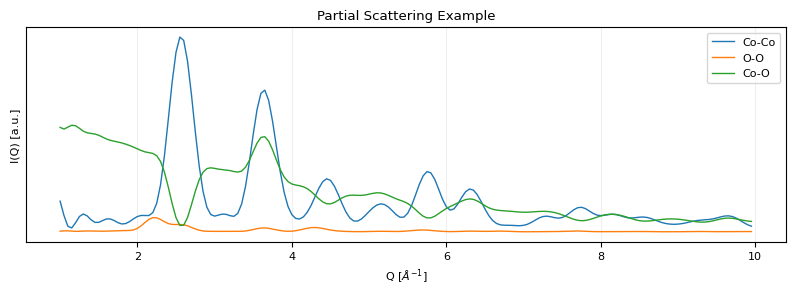

In [8]:
# Create an instance of DebyeCalculator with appropriate parameters
calc = DebyeCalculator(qmin=1.0, qmax=10.0, qstep=0.05)

# Get path to .xyz file
path_to_xyz_file = "debyecalculator/data/AntiFluorite_Co2O_r10.xyz"

# Generate partial intensities
q, iq_CoCo = calc.iq(path_to_xyz_file, partial = "Co-Co")
q, iq_OO = calc.iq(path_to_xyz_file, partial = "O-O")
q, iq_CoO = calc.iq(path_to_xyz_file, partial = "Co-O")

# Plot each individual partial scattering
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(q, iq_CoCo, label='Co-Co')
ax.plot(q, iq_OO, label='O-O')
ax.plot(q, iq_CoO, label='Co-O')

ax.set(xlabel='Q [$Å^{-1}$]', ylabel='I(Q) [a.u.]', yticks=[], title="Partial Scattering Example")
ax.legend()
ax.grid(alpha=0.2)

fig.tight_layout()

plt.show()

As mentioned in the **"notice"** above, if we want to combine these, you'll notice that the three scattering profiles do not combine to the original profile. This is due to the fact that at each intance of calculating the $I(Q)$, `DebyeCalculator` adds the self-scattering for each atom in the partial structure. When combining the profiles, this results in a double-counting of some of the scatteres. The scattering functions in `DebyeCalculator` allows you to enable/disable the self-scattering. With this we can recombine the signals and get back the original.

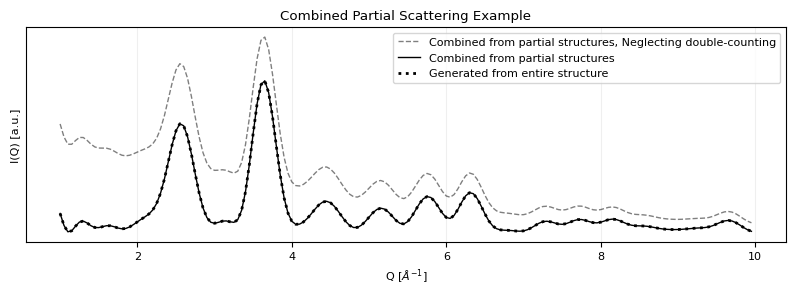

In [9]:
# Create an instance of DebyeCalculator with appropriate parameters
calc = DebyeCalculator(qmin=1.0, qmax=10.0, qstep=0.05)

# Get path to .xyz file
path_to_xyz_file = "debyecalculator/data/AntiFluorite_Co2O_r10.xyz"

# Generate partial intensities neglecting double-counting
q, iq_CoCo = calc.iq(path_to_xyz_file, partial = "Co-Co")
q, iq_OO = calc.iq(path_to_xyz_file, partial = "O-O")
q, iq_CoO = calc.iq(path_to_xyz_file, partial = "Co-O")

iq_combined_false = iq_CoCo + iq_OO + iq_CoO

# Let's generate the partial intensities, but skipping the self-scattering in the case of the "Co-O" interaction
q, iq_CoCo = calc.iq(path_to_xyz_file, partial = "Co-Co")
q, iq_OO = calc.iq(path_to_xyz_file, partial = "O-O")
q, iq_CoO = calc.iq(path_to_xyz_file, partial = "Co-O", include_self_scattering=False)

iq_combined = iq_CoCo + iq_OO + iq_CoO

# Let's then generate the full profile
q, iq = calc.iq(path_to_xyz_file)

# Plot each individual partial scattering and the combined
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(q, iq_combined_false, label='Combined from partial structures, Neglecting double-counting', ls='--', c='k', alpha=0.5)
ax.plot(q, iq_combined, label='Combined from partial structures', c='k')
ax.plot(q, iq, label='Generated from entire structure', ls=':', c='k', lw=2)

ax.set(xlabel='Q [$Å^{-1}$]', ylabel='I(Q) [a.u.]', yticks=[], title="Combined Partial Scattering Example")
ax.legend()
ax.grid(alpha=0.2)

fig.tight_layout()

plt.show()

Partial scattering can also be applied to the PDF calculations.

**Note:** In this case, there's no need to worry about double counting, as self-scattering is not included in the PDF calculations.

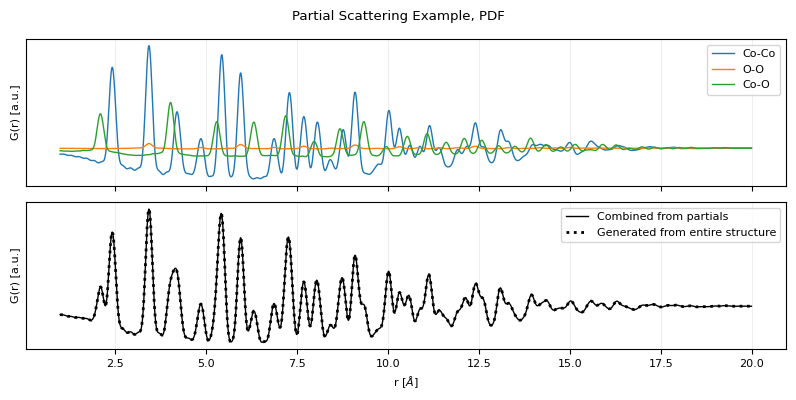

In [10]:
# Create an instance of DebyeCalculator with appropriate parameters
calc = DebyeCalculator(rmin=1.0, rmax=20.0)

# Get path to .xyz file
path_to_xyz_file = "debyecalculator/data/AntiFluorite_Co2O_r10.xyz"

# Generate partials
r, gr_CoCo = calc.gr(path_to_xyz_file, partial = "Co-Co")
r, gr_OO = calc.gr(path_to_xyz_file, partial = "O-O")
r, gr_CoO = calc.gr(path_to_xyz_file, partial = "Co-O")

gr_combined = gr_CoCo + gr_OO + gr_CoO

# Generate full profile
r, gr = calc.gr(path_to_xyz_file)

# Plot each individual partial scattering
fig, axes = plt.subplots(2,1,figsize=(8,4),sharex=True)

axes[0].plot(r, gr_CoCo, label='Co-Co', lw=1)
axes[0].plot(r, gr_OO, label='O-O', lw=1)
axes[0].plot(r, gr_CoO, label='Co-O', lw=1)

axes[1].plot(r, gr_combined, label='Combined from partials', c='k')
axes[1].plot(r, gr, label='Generated from entire structure', c='k', ls=':', lw=2)

for ax in axes:
    ax.set(xlabel='r [$Å$]', ylabel='G(r) [a.u.]', yticks=[])
    ax.legend()
    ax.grid(alpha=0.2)

axes[0].set_xlabel("")
fig.suptitle("Partial Scattering Example, PDF")
fig.tight_layout()

plt.show()

# Particle Playground

In the following sections, we will dive into how the `DebyeCalculator` can be utilized to model and analyze the scattering properties of simulated nanoparticles. We’ve prepared several examples that demonstrate how to simulate particles with core-shell structures, substitutional alloy particles, and toy-model intermetallic alloys. Feel free to experiment and create your own models to explore the full capabilities of `DebyeCalculator`.

### Substitutional alloy particles

Here is a simple example with substitutional bi-metallic alloys with varying ratios of the constituent metals.

In [17]:
# Define parameters for generating substitutional alloy models
base_element = 'Pd'                # Base element in the alloy
substitute_element = 'Ni'           # Element to substitute into the alloy
lattice_constant = 3.89            # Lattice constant in Ångströms
size = (10, 10, 10)                # Dimensions of the particle (in lattice units)
substitution_ratios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # Different substitution ratios to explore
radius = 15.0                      # Total particle radius in Ångströms

# Generate substitutional alloy models with varying substitution ratios
sub_alloy_models = generate_substitutional_alloy_models(
    base_element=base_element,
    substitute_element=substitute_element, 
    lattice_constant=lattice_constant,
    size=size,
    substitution_ratios=substitution_ratios,
    radius=radius,
)


We can run the following cell to visualize the particles. <br> <b>Notice</b> how we are cutting the particles in half when visualizing.

Visualizing substitutional alloy models...:   0%|          | 0/6 [00:00<?, ?it/s]

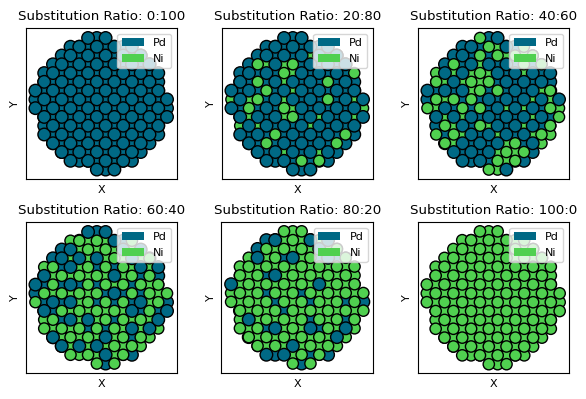

In [18]:
# Precompute colors and legend elements for base and substitute materials
base_color = jmol_colors[chemical_symbols.index(base_element)]
substitute_color = jmol_colors[chemical_symbols.index(substitute_element)]
legend_elements = [
    Patch(facecolor=base_color, label=base_element),
    Patch(facecolor=substitute_color, label=substitute_element),
]

# Convert substitution ratios into strings for labeling (e.g., "20:80")
substitution_ratios_str = [f"{int(np.ceil(r * 100))}:{int(np.floor(100 - r * 100))}" for r in substitution_ratios]

# Visualization setup
fig, axes = plt.subplots(2, 3, figsize=(6, 4))
axes = axes.ravel()

# Loop through each substitutional alloy model for visualization
for i in tqdm(range(len(substitution_ratios)), total=len(substitution_ratios), desc='Visualizing substitutional alloy models...'):
    # Cut the particle in half for better visualization and plot it
    structure = sub_alloy_models[i][sub_alloy_models[i].get_positions()[:, 2] <= 0]
    plot_atoms(structure, axes[i], show_unit_cell=0)
    
    # Set plot labels, title, and legend
    axes[i].set(
        xlabel='X', 
        ylabel='Y', 
        title=f'Substitution Ratio: {substitution_ratios_str[i]}', 
        xticks=[], 
        yticks=[]
    )
    axes[i].legend(handles=legend_elements, loc='upper right')

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()


Using the `DebyeCalculator` we can simulate the I(Q) of all the particles at once and visualize how the signal intensity changes. <br> <b> Notice </b> how we are able to pass the entire list of ASE particle models to the `iq` method at once.

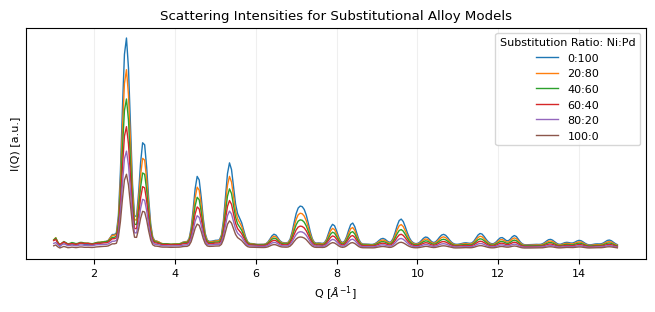

In [19]:
# Calculate scattering intensities for all substitutional alloy models
calc = DebyeCalculator(qmin=1, qmax=15, qstep=0.05)
iq_output = calc.iq(sub_alloy_models)

# Plotting the scattering intensities
fig, ax = plt.subplots(figsize=(8, 3))

# Plot each I(Q) curve with a unique color from the colormap
for i, (q, iq) in enumerate(iq_output):
    ax.plot(q, iq, label=f'{substitution_ratios_str[i]}')

# Set plot labels, title, and grid
ax.set(
    xlabel='Q [$Å^{-1}$]', 
    ylabel='I(Q) [a.u.]', 
    yticks=[], 
    title='Scattering Intensities for Substitutional Alloy Models'
)
ax.grid(alpha=0.2)

# Add a legend to differentiate the curves
ax.legend(loc='upper right', title=f'Substitution Ratio: {substitute_element}:{base_element}')

# Display the plot
plt.show()

## Intermetallic particles

Here is an example that compares an intermetallic particle (with periodic substitutional planes), a random mixture particle and a generic monometallic particle.

In [20]:
# Define parameters for generating various nanoparticle models
base_element = 'Pd'             # Base element for the models
substitute_element = 'Ni'       # Element to substitute into the models
lattice_constant = 3.89         # Lattice constant in Ångströms
size = (15, 15, 15)             # Dimensions of the particle (in lattice units)
radius = 25.0                   # Particle radius in Ångströms
plane_spacing = 2               # Spacing between substitution planes (in lattice units)
plane_orientation = 'x'         # Orientation of the planes ('x', 'y', or 'z')

# Generate a periodic plane substitution model
periodic_plane_model = generate_periodic_plane_substitution(
    base_element=base_element, 
    substitute_element=substitute_element, 
    lattice_constant=lattice_constant, 
    size=size, 
    radius=radius,
    plane_spacing=plane_spacing, 
    plane_orientation=plane_orientation
)

# Generate a substitutional alloy spherical particle model with 50% substitution ratio
sub_model = generate_substitutional_alloy_models(
    base_element=base_element,
    substitute_element=substitute_element, 
    substitution_ratios=[0.5],   # 50% substitution ratio
    lattice_constant=lattice_constant,
    size=size,
    radius=radius,
)[0]  # Access the first (and only) model in the list

# Generate a generic spherical particle model composed entirely of the base element
generic_model = generate_spherical_particle(
    element=base_element,
    lattice_constant=lattice_constant,
    size=size,
    radius=radius,
)

We can run the following cell to visualize the particles. <br> <b>Notice</b> how we rotating the particle such that we can see the periodicity.

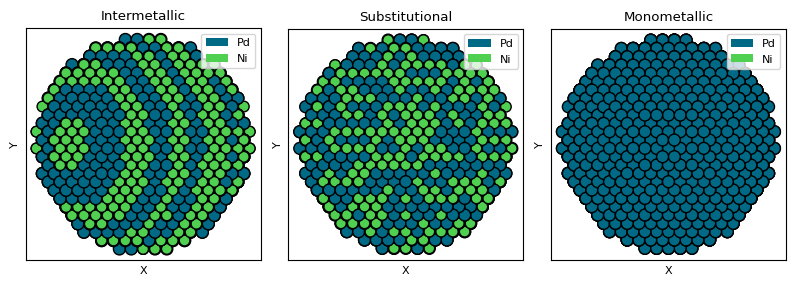

In [21]:
# Precompute colors and legend elements for base and substitute materials
base_color = jmol_colors[chemical_symbols.index(base_element)]
substitute_color = jmol_colors[chemical_symbols.index(substitute_element)]
legend_elements = [
    Patch(facecolor=base_color, label=base_element),
    Patch(facecolor=substitute_color, label=substitute_element),
]

# Visualization of the periodic plane model, substitutional model, and generic spherical particle
fig, axes = plt.subplots(1, 3, figsize=(8, 3))  # Adjusted figsize for better spacing

# Plot the periodic plane model (Intermetallic)
axes[0].set(title='Intermetallic', xlabel='X', ylabel='Y', xticks=[], yticks=[])
axes[0].legend(handles=legend_elements, loc='upper right')
plot_atoms(periodic_plane_model, axes[0], show_unit_cell=0, rotation=('90x,45y,0z'))

# Plot the substitutional alloy model (Substitutional)
axes[1].set(title='Substitutional', xlabel='X', ylabel='Y', xticks=[], yticks=[])
axes[1].legend(handles=legend_elements, loc='upper right')
plot_atoms(sub_model, axes[1], show_unit_cell=0, rotation=('90x,45y,0z'))

# Plot the generic spherical particle model (Monometallic)
axes[2].set(title='Monometallic', xlabel='X', ylabel='Y', xticks=[], yticks=[])
axes[2].legend(handles=legend_elements, loc='upper right')
plot_atoms(generic_model, axes[2], show_unit_cell=0, rotation=('90x,45y,0z'))

# Adjust layout to prevent overlap and ensure clarity
fig.tight_layout()
plt.show()

Using the `DebyeCalculator` we can simulate the I(Q) of all the particles at once and visualize how the signal intensity changes. <br> <b> Notice </b> how we are able to pass the entire list of ASE particle models to the `iq` method at once.

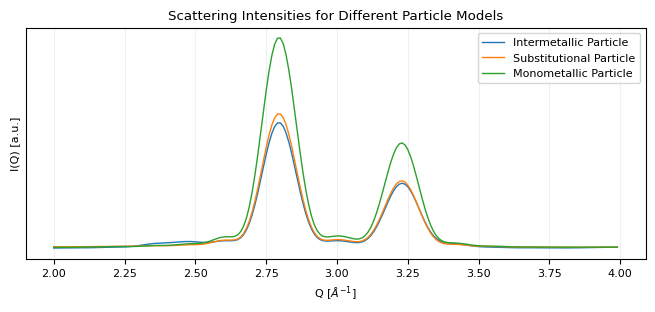

In [22]:
# Calculate Pair Distribution Functions (PDFs) for all three models
calc = DebyeCalculator(qmin=2.0, qmax=4.0, qstep=0.01)
iq_output_inter = calc.iq(periodic_plane_model)
iq_output_sub = calc.iq(sub_model)
iq_output_mono = calc.iq(generic_model)

# Plotting the scattering intensities to compare the models
fig, ax = plt.subplots(figsize=(8, 3))

# Plot I(Q) for the periodic plane substitution model (Intermetallic Particle)
x_inter, y_inter = iq_output_inter
ax.plot(x_inter, y_inter, label='Intermetallic Particle')

# Plot I(Q) for the substitutional alloy model (Substitutional Particle)
x_sub, y_sub = iq_output_sub
ax.plot(x_sub, y_sub, label='Substitutional Particle')

# Plot I(Q) for the generic spherical particle model (Monometallic Particle)
x_mono, y_mono = iq_output_mono
ax.plot(x_mono, y_mono, label='Monometallic Particle')

# Set plot labels, title, and grid
ax.set(
    xlabel='Q [$Å^{-1}$]', 
    ylabel='I(Q) [a.u.]', 
    yticks=[], 
    title='Scattering Intensities for Different Particle Models'
)
ax.grid(alpha=0.2)

# Add a legend to differentiate the curves
ax.legend(loc='upper right')

# Display the plot
plt.show()

---
# Interactive Mode
The interact mode of `DebyeCalculator` provides a one-click interface, where the user can
update parameters and visualise $𝐼(𝑄)$, $𝑆(𝑄)$, $𝐹(𝑄)$, and $𝐺(𝑟)$. Additionally, the $𝐼(𝑄)$, $𝑆(𝑄)$, $𝐹(𝑄)$,
$𝐺(𝑟)$, and `.xyz` file can be downloaded, including metadata.

In [23]:
DebyeCalculator().interact()

---
# Useful For Developers

## Profiling Performance with DebyeCalculator

The `DebyeCalculator` class comes with a built-in profiler that allows you to measure the time taken to execute specific parts of the code. This can be helpful in identifying performance bottlenecks and optimizing your calculations.

The profiler in `DebyeCalculator` is an instance of the `Profiling` class, which tracks the time taken by various methods in the class and provides summary statistics.

### Profiler Demonstration

The next cell demonstrates the use of the profiler by generating scattering for nanoparticles from a `.cif` file. 

In [24]:
# Load the structure file
structure_path = 'debyecalculator/data/AntiFluorite_Co2O.cif'

# Profiling for single particle with radius r = 10.0 Å
debye_calc = DebyeCalculator(device='cuda', profile=True, qmin=1, qmax=25, batch_size=10000)
for _ in trange(50):
    _ = debye_calc.gr(structure_path, radii = 10.0)

print(debye_calc.profiler.summary(prefix='Timing per scattering generation:'))

  0%|          | 0/50 [00:00<?, ?it/s]

Timing per scattering generation:
   -> Setup structures and form factors: 205.614ms +- 47.828ms (91.27%) 
   -> G(r): 18.480ms +- 9.584ms (8.20%) 
   -> Batching and Distances: 1.176ms +- 0.182ms (0.52%) 
Total: 225.269ms


The next cell demonstrates the use of the profiler by generating scattering for nanoparticles from a `.xyz` file. 

In [25]:
# Load the structure file
structure_path = 'debyecalculator/data/AntiFluorite_Co2O_r10.xyz'

# Profiling for single particle with radius r = 10.0 Å
debye_calc = DebyeCalculator(device='cuda', profile=True, qmin=1, qmax=25, batch_size=10000)
for _ in trange(50):
    r, gr = debye_calc.gr(structure_path)

print(debye_calc.profiler.summary(prefix='Timing per scattering generationn:'))

  0%|          | 0/50 [00:00<?, ?it/s]

Timing per scattering generationn:
   -> G(r): 14.702ms +- 1.488ms (78.19%) 
   -> Setup structures and form factors: 3.009ms +- 0.404ms (16.00%) 
   -> Batching and Distances: 1.091ms +- 0.188ms (5.80%) 
Total: 18.802ms


**Notice** that if you already have access to `.xyz`-files, you can simulate the scattering much faster.